# Курс «Введение в нейронные сети»

## Урок 8. GAN

### Домашняя работа к уроку 7

In [1]:
import tensorflow as tf

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [3]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
def random_crop(image):
    '''
    Обрезать изображение по размерам.
    '''
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image

In [5]:
def normalize(image):
    '''
    Нормализовать изображения.
    '''
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [6]:
def random_jitter(image):
    '''
    Потрясли изображение.
    '''
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    return image

In [7]:
def preprocess_image_train(image, label):
    '''
    Предподготовка обучения.
    '''
    image = random_jitter(image)
    image = normalize(image)
    return image

In [8]:
def preprocess_image_test(image, label):
    '''
    Предподготовка тестирования.
    '''
    image = normalize(image)
    return image

In [9]:
def discriminator_loss(real, generated):
    '''
    Потери дискриминатора.
    '''
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [10]:
def generator_loss(generated):
    '''
    Потери генератора.
    '''
    return loss_obj(tf.ones_like(generated), generated)

In [11]:
def calc_cycle_loss(real_image, cycled_image):
    '''
    Общие потери.
    '''
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [12]:
def identity_loss(real_image, same_image):
    '''
    Потери.
    '''
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [13]:
def generate_images(model, test_input):
    '''
    Генерация изображения.
    '''
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [14]:
@tf.function
def train_step(real_x, real_y):
    '''
    Шаг обучения.
    '''
    # persistent установлен в значение True, поскольку лента
    # используется более одного раза для вычисления градиентов.
    with tf.GradientTape(persistent=True) as tape:
        # Генератор G преобразует X -> Y
        # Генератор F преобразует Y -> X.
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x и same_y are используется для вычисления потерь.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # рассчитывыаем потери.
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Полные потери генератора = состязательная потеря + потеря цикла
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
    # Рассчитываем градиенты для генератора и дискриминатора
    generator_g_gradients = tape.gradient(total_gen_g_loss,  generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Применим градиенты к оптимизатору.
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [15]:
BUFFER_SIZE = 1000
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 10

#### Задание 1

Попробуйте улучшить работу нейронной сети рассмотренной в методическом пособии. Приложите анализ. Приложете лучшее сгенерированное изображение к уроку.

Обратите внимание для запуска нейронной сети понадобиться tensorflow 2.1.0 и минимум 8gb опер. памяти (если запускать на процессоре).

Загрузим датасет

In [16]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)

In [17]:
train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [18]:
train_horses = train_horses.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
train_zebras = train_zebras.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
test_horses = test_horses.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
test_zebras = test_zebras.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

In [19]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

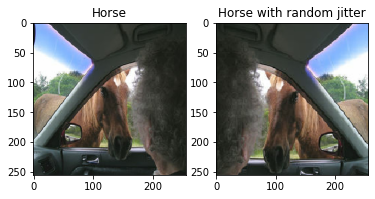

In [20]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

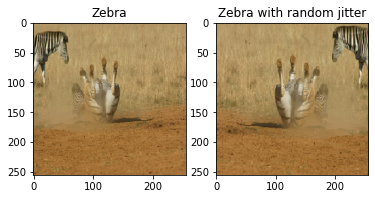

In [21]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

In [22]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

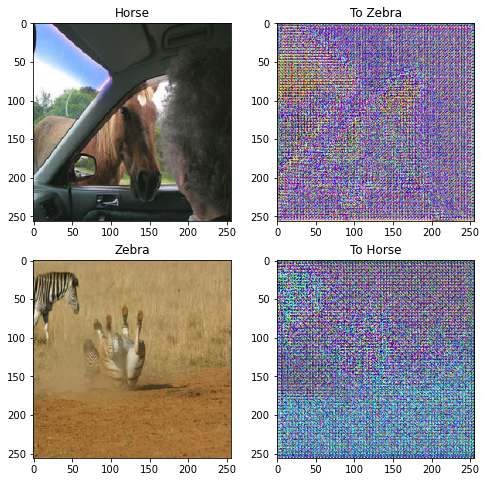

In [23]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

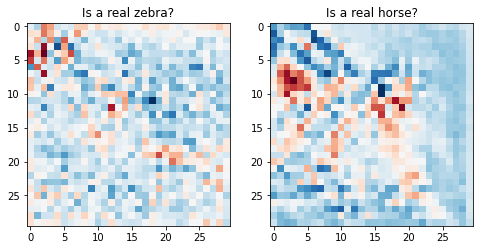

In [24]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [25]:
LAMBDA = 10

In [26]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [28]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

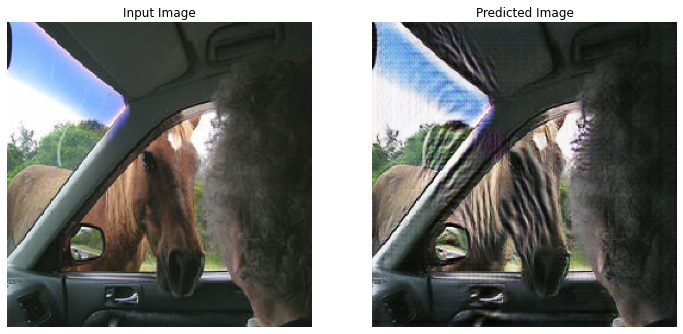

Сохранение чекпоинта на эпоху 10 в ./checkpoints/train\ckpt-2
Время, потраченное на эпоху 10 is 4690.869722366333 с



In [29]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    # Используем согласованные изображения (sample_horse), чтобы видеть прогресс обучения модели.
    generate_images(generator_g, sample_horse)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Сохранение чекпоинта на эпоху {} в {}'.format(epoch+1, ckpt_save_path))

    print ('Время, потраченное на эпоху {} в {} с\n'.format(epoch + 1, time.time()-start))

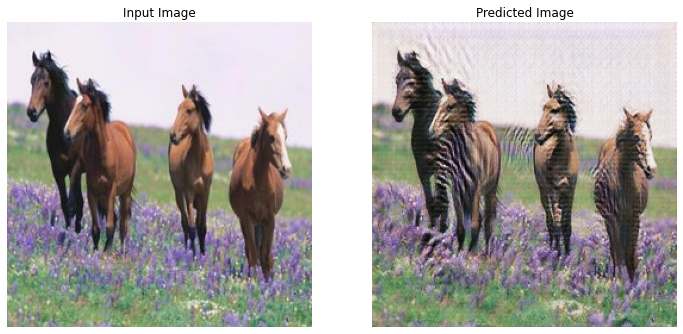

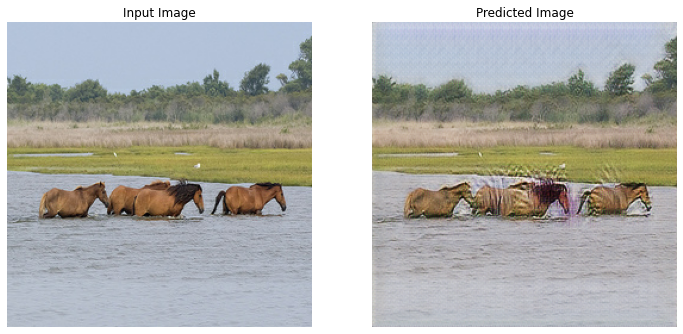

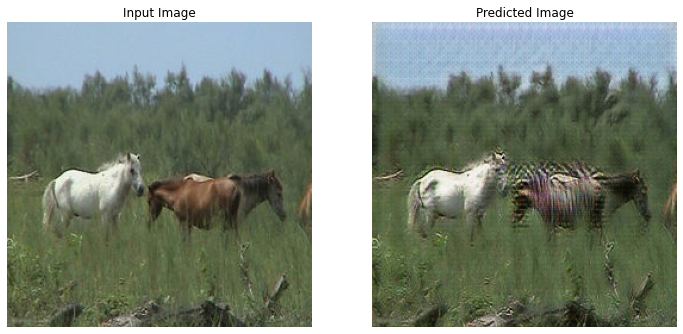

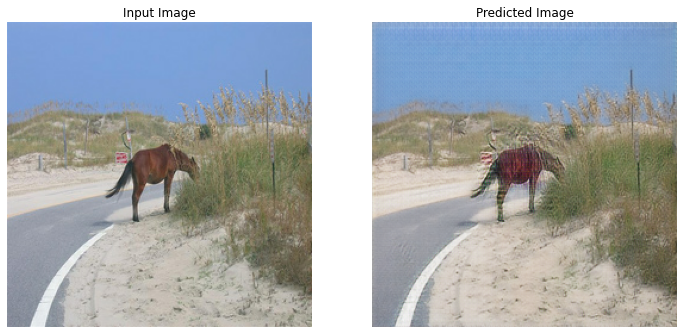

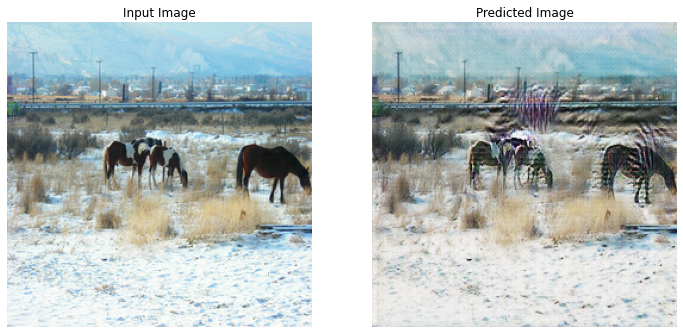

In [30]:
for inp in test_horses.take(5):
    generate_images(generator_g, inp)